In [78]:
import os
import vtk
import numpy as np
from vtk.util import numpy_support
from scipy.interpolate import interp1d

TARGET_N = 240

def resample_array(arr, target_len):
    original_len = len(arr)
    x_old = np.linspace(0, 1, original_len)
    x_new = np.linspace(0, 1, target_len)
    f = interp1d(x_old, arr, kind='linear', axis=0, fill_value="extrapolate")
    return f(x_new)

def read_vtk_point_cell_data(filepath):
    reader = vtk.vtkPolyDataReader()
    reader.SetFileName(filepath)
    reader.Update()
    polydata = reader.GetOutput()

    # 提取按连接顺序排列的坐标
    num_points = polydata.GetNumberOfPoints()
    num_lines = polydata.GetNumberOfLines()
    if num_lines != 1:
        raise ValueError(f"{filepath} contains {num_lines} lines (expected 1)")

    line = polydata.GetLines().GetData()
    line_np = numpy_support.vtk_to_numpy(line)
    line_point_ids = line_np[1:]
    coords = np.array([polydata.GetPoint(pid) for pid in line_point_ids])

    # 插值 coords
    resampled_coords = resample_array(coords, TARGET_N)

    # 插值 point data
    point_data = {}
    pd = polydata.GetPointData()
    for i in range(pd.GetNumberOfArrays()):
        array = pd.GetArray(i)
        if array:
            name = array.GetName()
            data = numpy_support.vtk_to_numpy(array)
            if len(data) == len(coords):  # 只处理与 coords 长度一致的
                resampled = resample_array(data, TARGET_N)
                point_data[name] = resampled.astype(data.dtype)
            else:
                point_data[name] = data  # 保留不变

    # 不处理 cell_data，直接保留原始数据
    cell_data = {}
    cd = polydata.GetCellData()
    for i in range(cd.GetNumberOfArrays()):
        array = cd.GetArray(i)
        if array:
            name = array.GetName()
            data = numpy_support.vtk_to_numpy(array)
            cell_data[name] = data

    return point_data, cell_data, resampled_coords

def batch_read_vtk_data(directory):
    results = {}
    for fname in os.listdir(directory):
        if fname.lower().endswith(".vtk"):
            full_path = os.path.join(directory, fname)
            point_data, cell_data, coords = read_vtk_point_cell_data(full_path)
            results[fname] = {
                'point_data': point_data,
                'cell_data': cell_data,
                'coords': coords
            }
    return results

# 用法示例
base_dir = r"D:\!BraVa_src\ica_results\vmtkgeometry_91"
vtk_data_dict = batch_read_vtk_data(base_dir)


In [79]:
for fname, content in vtk_data_dict.items():
    point_attrs = content['point_data']
    cell_attrs = content['cell_data']
    coords = content['coords']

    print(f"{fname}:")
    print(f"  Point attributes ({len(point_attrs)}): {list(point_attrs.keys())}")
    print(f"  Cell attributes ({len(cell_attrs)}): {list(cell_attrs.keys())}")
    print(f"  Points (coords): {coords.shape[0]}")
    print("-" * 60)


BG0001_L.vtk:
  Point attributes (5): ['Curvature', 'Torsion', 'FrenetTangent', 'FrenetNormal', 'FrenetBinormal']
  Cell attributes (2): ['Length', 'Tortuosity']
  Points (coords): 240
------------------------------------------------------------
BG0001_R.vtk:
  Point attributes (5): ['Curvature', 'Torsion', 'FrenetTangent', 'FrenetNormal', 'FrenetBinormal']
  Cell attributes (2): ['Length', 'Tortuosity']
  Points (coords): 240
------------------------------------------------------------
BG0003_L.vtk:
  Point attributes (5): ['Curvature', 'Torsion', 'FrenetTangent', 'FrenetNormal', 'FrenetBinormal']
  Cell attributes (2): ['Length', 'Tortuosity']
  Points (coords): 240
------------------------------------------------------------
BG0003_R.vtk:
  Point attributes (5): ['Curvature', 'Torsion', 'FrenetTangent', 'FrenetNormal', 'FrenetBinormal']
  Cell attributes (2): ['Length', 'Tortuosity']
  Points (coords): 240
------------------------------------------------------------
BG0004_L.vtk:
  

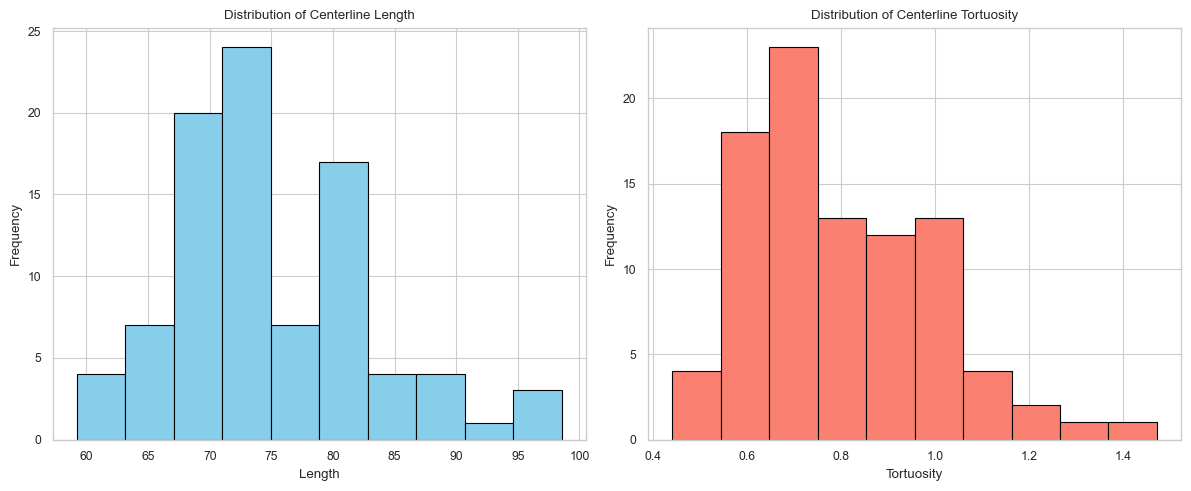

In [80]:
import matplotlib.pyplot as plt
import numpy as np

# 收集所有 length 和 tortuosity 数据
all_lengths = []
all_torts = []

for content in vtk_data_dict.values():
    cell_data = content['cell_data']
    if 'Length' in cell_data and 'Tortuosity' in cell_data:
        all_lengths.extend(cell_data['Length'])
        all_torts.extend(cell_data['Tortuosity'])

all_lengths = np.array(all_lengths)
all_torts = np.array(all_torts)

# 绘图
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(all_lengths, bins=10, color='skyblue', edgecolor='black')
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.title("Distribution of Centerline Length")

plt.subplot(1, 2, 2)
plt.hist(all_torts, bins=10, color='salmon', edgecolor='black')
plt.xlabel("Tortuosity")
plt.ylabel("Frequency")
plt.title("Distribution of Centerline Tortuosity")

plt.tight_layout()
plt.show()


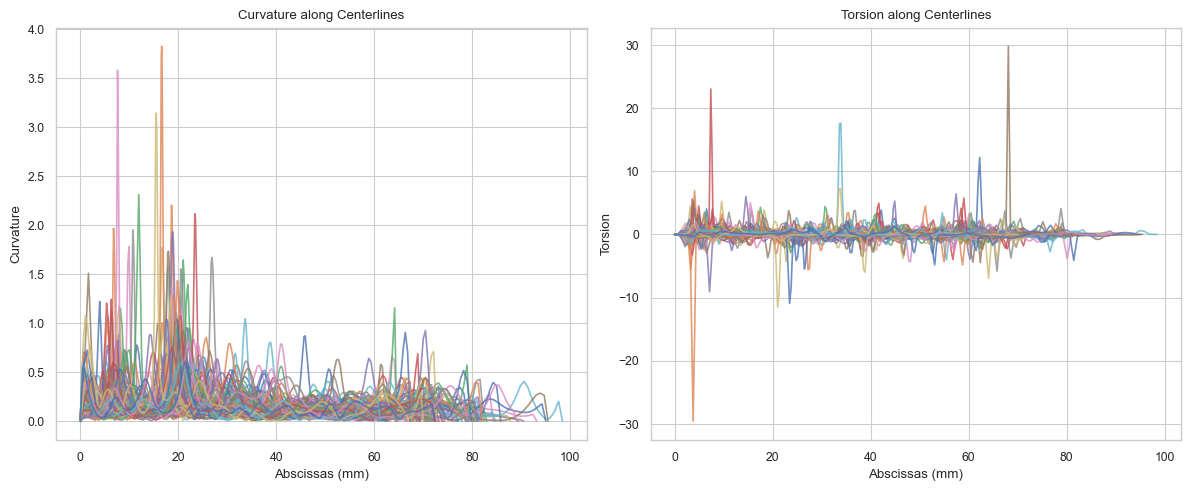

In [81]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# curvature subplot
plt.subplot(1, 2, 1)
for fname, content in vtk_data_dict.items():
    coords = content['coords']
    pdata = content['point_data']
    if 'Curvature' in pdata:
        diffs = np.linalg.norm(np.diff(coords, axis=0), axis=1)
        arc_length = np.concatenate([[0], np.cumsum(diffs)])
        plt.plot(arc_length, pdata['Curvature'], label=fname, alpha=0.8)
plt.title("Curvature along Centerlines")
plt.xlabel("Abscissas (mm)")
plt.ylabel("Curvature")
plt.grid(True)

# torsion subplot
plt.subplot(1, 2, 2)
for fname, content in vtk_data_dict.items():
    coords = content['coords']
    pdata = content['point_data']
    if 'Torsion' in pdata:
        diffs = np.linalg.norm(np.diff(coords, axis=0), axis=1)
        arc_length = np.concatenate([[0], np.cumsum(diffs)])
        plt.plot(arc_length, pdata['Torsion'], label=fname, alpha=0.8)
plt.title("Torsion along Centerlines")
plt.xlabel("Abscissas (mm)")
plt.ylabel("Torsion")
plt.grid(True)

plt.tight_layout()
plt.show()


In [82]:
from io import StringIO
import sys
import re
import csv

class OutputCatcher:
    def __init__(self):
        self._stdout = sys.stdout
        self.buffer = StringIO()

    def __enter__(self):
        sys.stdout = self.buffer
        return self

    def __exit__(self, *args):
        sys.stdout = self._stdout

    def get(self):
        return self.buffer.getvalue()

def parse_alignment_log(log_text):
    pattern_iter = re.compile(r"(updating step: r=|Iteration )(\d+)")
    pattern_residual = re.compile(r"Residual(?: Change)?: ([\d\.]+)")
    pattern_energy = re.compile(r"Residual Energy: ([\d\.]+)")

    results = {}
    current_iter = None

    for line in log_text.splitlines():
        iter_match = pattern_iter.search(line)
        if iter_match:
            current_iter = int(iter_match.group(2))
            if current_iter not in results:
                results[current_iter] = {'iter': current_iter}

        res_match = pattern_residual.search(line)
        if res_match and current_iter is not None:
            results[current_iter]['residual'] = float(res_match.group(1))

        ene_match = pattern_energy.search(line)
        if ene_match and current_iter is not None:
            results[current_iter]['energy'] = float(ene_match.group(1))

    # 转成列表并排序
    return [results[k] for k in sorted(results)]


def write_log_to_csv(results, filename):
    with open(filename, "w", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=["iter", "residual", "energy"])
        writer.writeheader()
        writer.writerows(results)
    print(f"[log] Wrote {len(results)} rows to {filename}")


[log] Wrote 20 rows to ./alignment_plain.csv
[log] Wrote 20 rows to ./alignment_weighted.csv


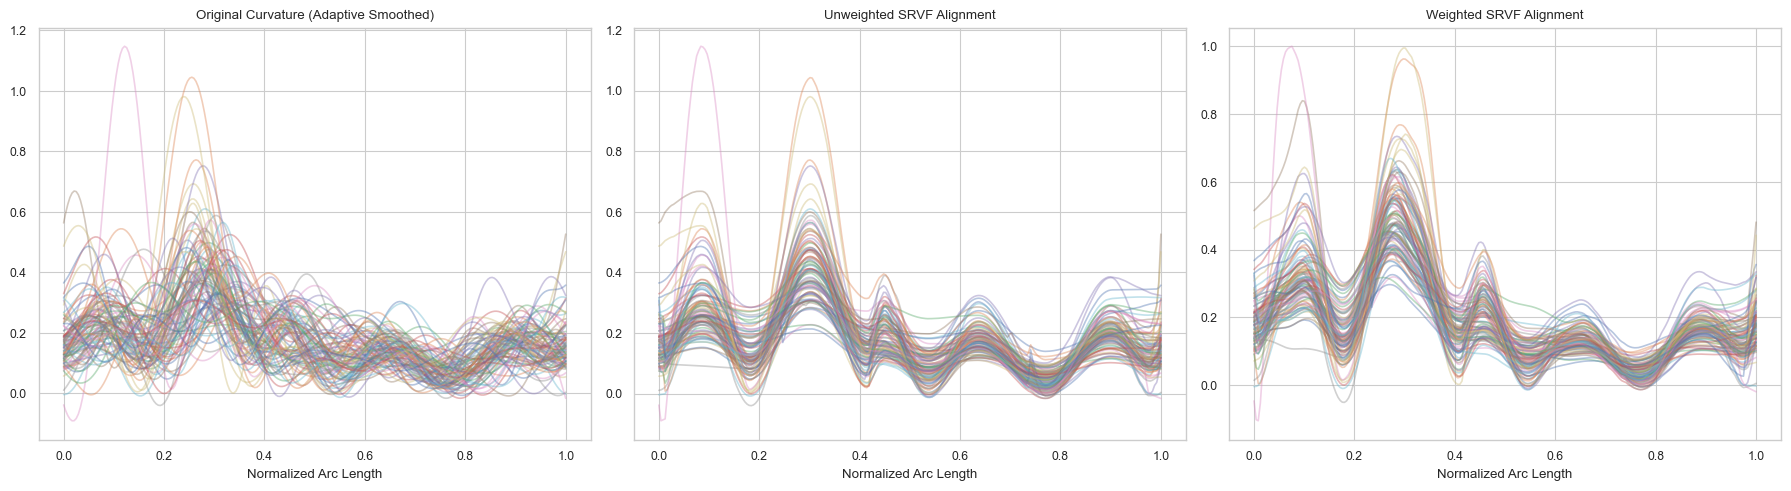

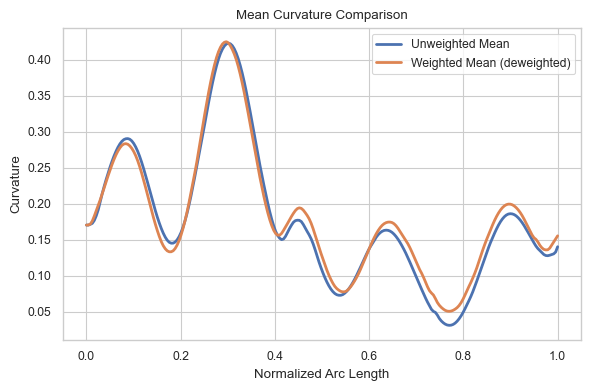

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.fft import fft, ifft
from scipy.signal import find_peaks
from fdasrsf.utility_functions import resamplefunction
from fdasrsf.time_warping import fdawarp
import seaborn as sns

sns.set(style="whitegrid", context="paper", font_scale=1)
# 参数
# # target_len = 200
# target_len = 500  # 目标长度
t_resample = np.linspace(0, 1, TARGET_N )
alpha_s = 0.75

# Fourier 平滑函数
def fourier_lowpass(signal, keep_ratio):
    N = len(signal)
    fhat = fft(signal)
    keep = int(N * keep_ratio)
    fhat[keep:-keep] = 0
    return np.real(ifft(fhat))

# 自适应平滑函数：使平滑后曲线具有约 5 个峰
def adaptive_fourier_smoothing(signal, peak_target=5, tol=1, max_iter=50):
    ratios = np.linspace(0.01, 0.2, 100)
    for r in ratios:
        smoothed = fourier_lowpass(signal, keep_ratio=r)
        peaks, _ = find_peaks(smoothed,
                                prominence=(np.max(smoothed) - np.min(smoothed)) * 0.08,
                                distance=TARGET_N  // 10  # 避免过密峰值
                            )
        if abs(len(peaks) - peak_target) <= tol:
            return smoothed
    return fourier_lowpass(signal, keep_ratio=0.03)

# 结构权重函数（使用自适应傅立叶平滑）
def composite_weight(curves, alpha_s=0.75):
    """
    使用 adaptive Fourier smoothing 后的结构强度生成逐点加权权重。
    - curves: ndarray of shape [T, N]
    - alpha_s: 放大系数（越大越强调曲率突变区域）
    
    返回:
        weights: ndarray of shape [T, N]
    """
    T, N = curves.shape

    # Step 1: 对每条曲线使用 adaptive smoothing
    smoothed_curves = np.stack([
        adaptive_fourier_smoothing(curves[:, i], peak_target=5, tol=1)
        for i in range(N)
    ], axis=1)

    # Step 2: 局部结构强度（曲率绝对值）
    mag = np.abs(smoothed_curves)

    # Step 3: 一致性系数（强调 across-curves 一致的区域）
    consistency = 1.0 / (np.std(smoothed_curves, axis=1) + 1e-5)
    consistency = (consistency - consistency.min()) / (consistency.max() - consistency.min() + 1e-8)
    consistency = consistency[:, None]  # shape [T, 1]

    # Step 4: 综合权重计算
    weights = (1 + alpha_s * mag) * (0.5 + 0.5 * consistency)

    # Step 5: 全局归一化
    weights /= (weights.mean() + 1e-8)

    return weights  # shape [T, N]


# 主流程
names = list(vtk_data_dict.keys())
resampled_curves = []

for name in names:
    curvature = vtk_data_dict[name]["point_data"]["Curvature"]
    coords = vtk_data_dict[name]["coords"]

    # 不再重新插值，只保留 smoothing（输入已经是500点）
    curvature = adaptive_fourier_smoothing(curvature, peak_target=5, tol=1)
    resampled_curves.append(curvature)


f = np.stack(resampled_curves).T
time = t_resample

# # 不加权对齐
# obj_plain = fdawarp(f.copy(), time)
# obj_plain.srsf_align(parallel=True, MaxItr=20, verbose=True)
with OutputCatcher() as capture_plain:
    obj_plain = fdawarp(f.copy(), time)
    obj_plain.srsf_align(parallel=True, MaxItr=20, verbose=True)

plain_log = capture_plain.get()
plain_results = parse_alignment_log(plain_log)
write_log_to_csv(plain_results, "./alignment_plain.csv")




# 加权对齐
W = composite_weight(f, alpha_s=alpha_s)
obj_weighted = fdawarp(f.copy(), time)
obj_weighted.custom_weights = W.mean(axis=0)  # 向自定义方法传权重
alpha_init = 0.05
# momentum_beta = 0.9
momentum_beta1= 0.9
momentum_beta2 = 0.999

# obj_weighted.srsf_align_weighted(
#     pointwise_weights=W,
#     MaxItr=50,
#     parallel=True,
#     alpha=alpha_init,
#     use_momentum=True,
#     # beta=momentum_beta
#     beta1=momentum_beta1,
#     beta2=momentum_beta2
# )
with OutputCatcher() as capture_weighted:
    obj_weighted.srsf_align_weighted(
        pointwise_weights=W,
        MaxItr=20,
        parallel=True,
        alpha=alpha_init,
        use_momentum=True,
        beta1=momentum_beta1,
        beta2=momentum_beta2
    )

weighted_log = capture_weighted.get()
weighted_results = parse_alignment_log(weighted_log)
write_log_to_csv(weighted_results, "./alignment_weighted.csv")




# 恢复加权后数据
f_weighted_unwrapped = obj_weighted.fn / W

# 可视化
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
for i in range(f.shape[1]):
    plt.plot(time, f[:, i], alpha=0.4)
plt.title("Original Curvature (Adaptive Smoothed)")
plt.xlabel("Normalized Arc Length")
plt.grid(True)

plt.subplot(1, 3, 2)
for i in range(f.shape[1]):
    plt.plot(time, obj_plain.fn[:, i], alpha=0.4)
plt.title("Unweighted SRVF Alignment")
plt.xlabel("Normalized Arc Length")
plt.grid(True)

plt.subplot(1, 3, 3)
for i in range(f.shape[1]):
    plt.plot(time, f_weighted_unwrapped[:, i], alpha=0.4)
plt.title("Weighted SRVF Alignment")
plt.xlabel("Normalized Arc Length")
plt.grid(True)

plt.tight_layout()
plt.show()

# 平均曲率比较
plt.figure(figsize=(6, 4))
plt.plot(time, obj_plain.fmean, label='Unweighted Mean', lw=2)
plt.plot(time, obj_weighted.fmean, label='Weighted Mean (deweighted)', lw=2)
plt.xlabel("Normalized Arc Length")
plt.ylabel("Curvature")
plt.title("Mean Curvature Comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


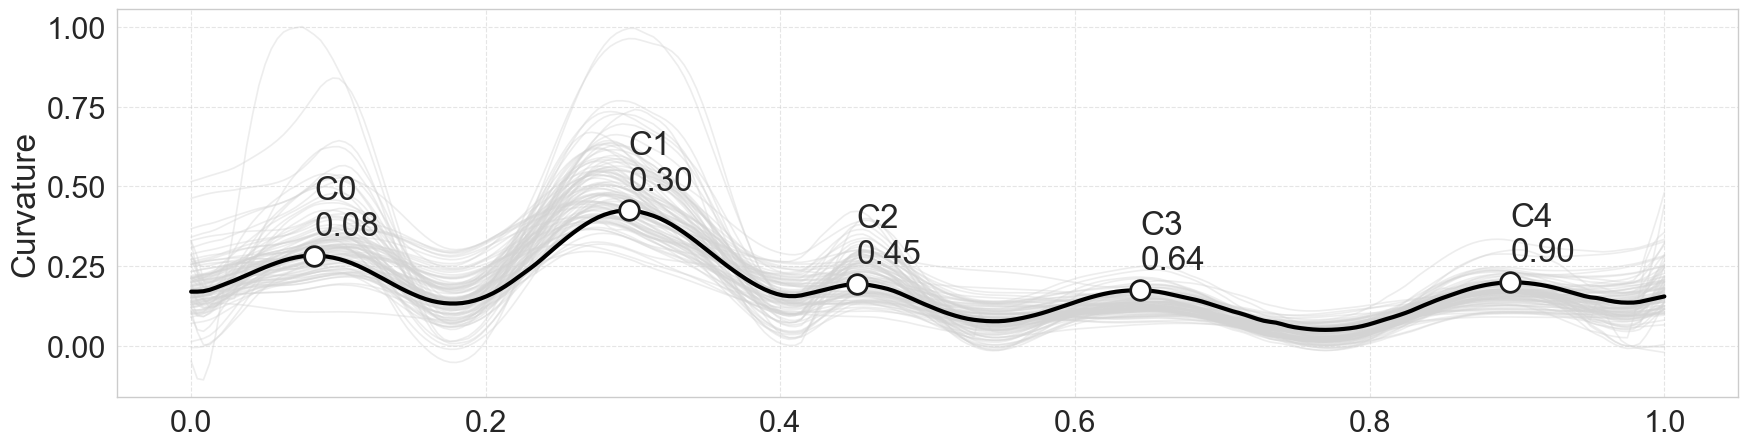

In [84]:
import seaborn as sns
from scipy.signal import find_peaks

sns.set(style="whitegrid", context="paper", font_scale=2.5)

# 计算去权重后的平均曲线
# mean_curve = obj_weighted.fmean / W.mean(axis=1)
mean_curve = obj_weighted.fmean

# 寻找峰值点
peaks, _ = find_peaks(
    mean_curve,
    prominence=(np.max(mean_curve) - np.min(mean_curve)) * 0.08,  # 自适应prominence
    distance=TARGET_N // 10                                     # 控制峰值间距（25点）
)

# 将峰值按 x 坐标排序（从左到右）
sorted_peaks = peaks[np.argsort(time[peaks])]

# 可视化
fig = plt.figure(figsize=(18, 5))
ax = fig.add_subplot(111)

# 所有对齐曲线
for i in range(f.shape[1]):
    ax.plot(time, f_weighted_unwrapped[:, i], alpha=0.4, color='lightgray')

# 平均曲线
ax.plot(time, mean_curve, label='Weighted Mean (deweighted)', lw=3, color='black')

# 标注峰值
ax.scatter(time[sorted_peaks], mean_curve[sorted_peaks],
           color='white', edgecolors='k', linewidths=2,
           s=200, zorder=10, label='Peaks')

# 添加标注文字 C0 ~ Cn 和对应高度
for i, idx in enumerate(sorted_peaks):
    peak_x = time[idx]
    peak_y = mean_curve[idx]
    ax.annotate(f"C{i}\n{peak_x:.2f}", xy=(peak_x, peak_y),
                xytext=(0, 10), textcoords='offset points',
                ha='left', va='bottom', fontsize=24,
                arrowprops=dict(arrowstyle='-', lw=1))

# 标签和网格
ax.set_ylabel("Curvature")
plt.grid(linestyle='--', alpha=0.5)
plt.tight_layout()
# plt.legend()
plt.show()


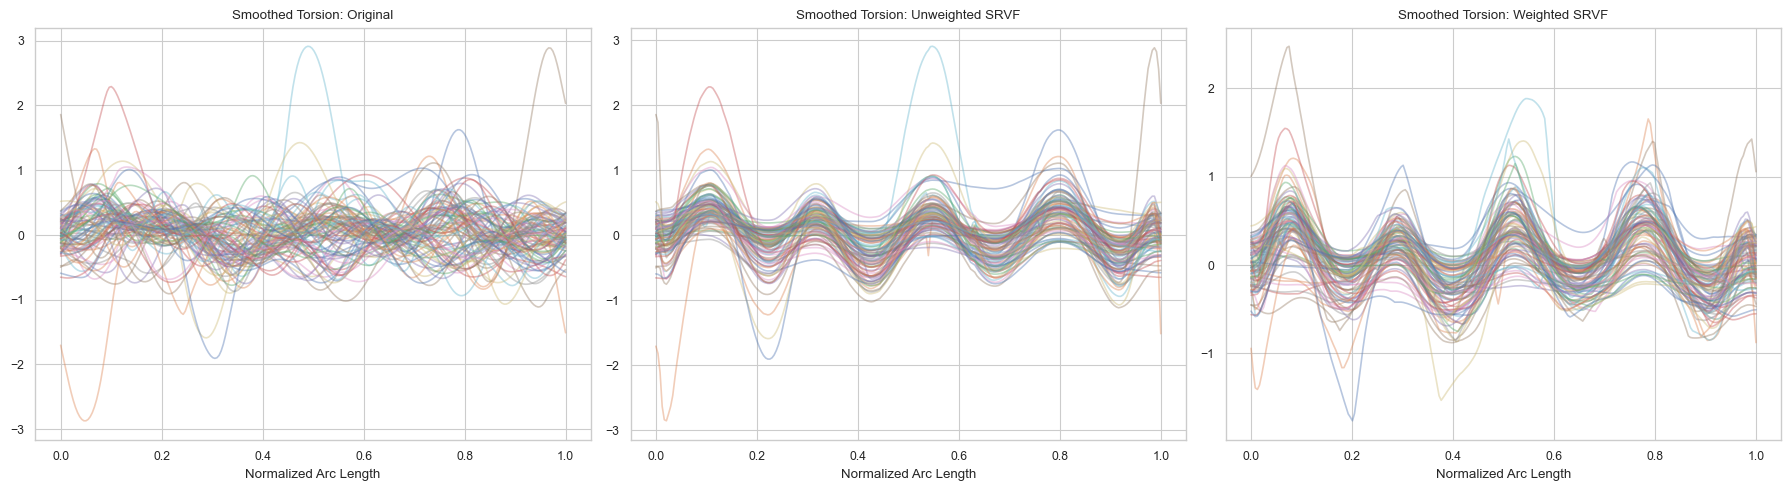

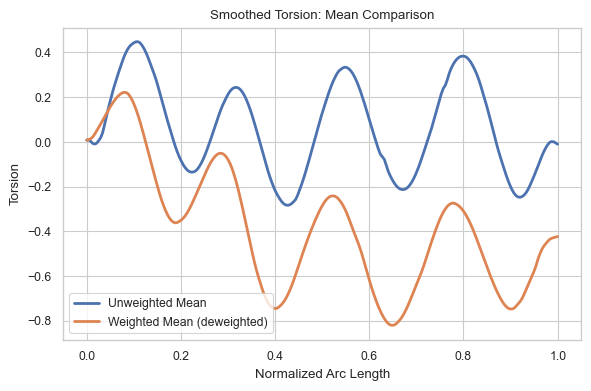

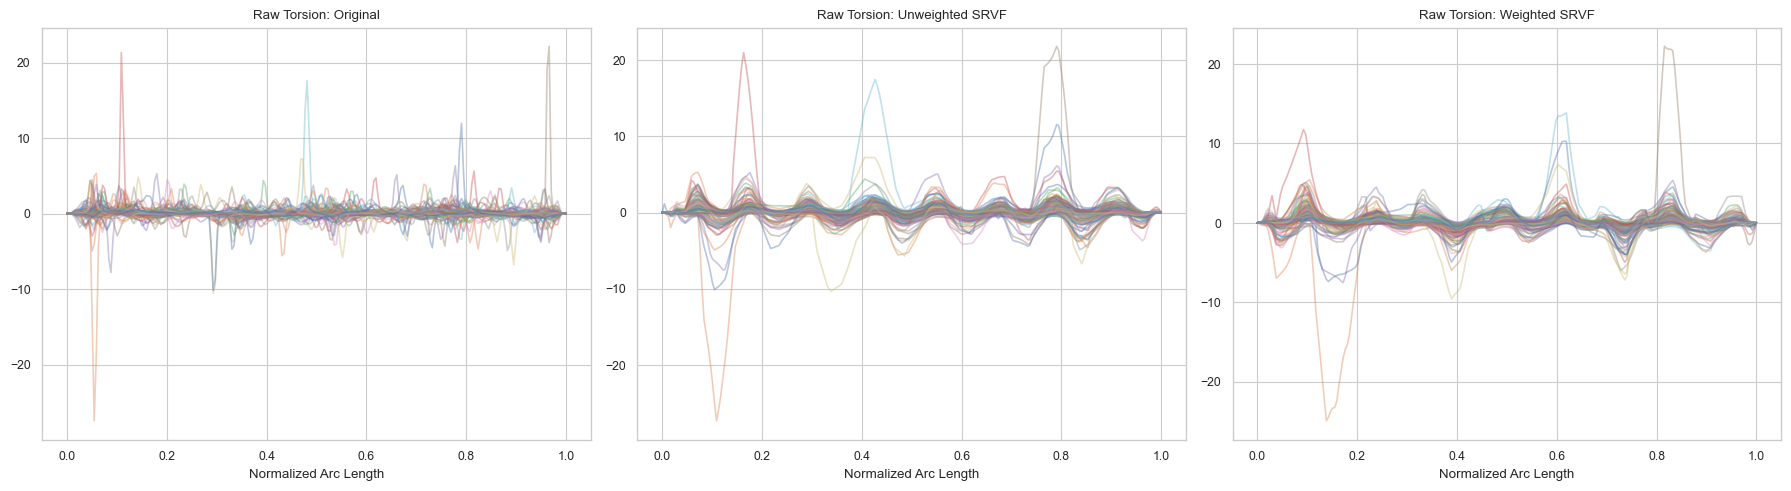

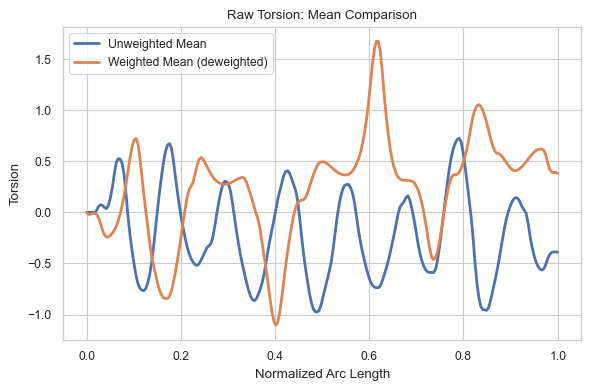

In [85]:
sns.set(style="whitegrid", context="paper", font_scale=1)

def resample_torsion_model(use_smoothing=True):
    resampled = []
    for name in names:
        coords = vtk_data_dict[name]["coords"]
        torsion = vtk_data_dict[name]["point_data"]["Torsion"]

        if use_smoothing:
            torsion = adaptive_fourier_smoothing(torsion, peak_target=5, tol=1)

        diffs = np.linalg.norm(np.diff(coords, axis=0), axis=1)
        abscissas = np.concatenate([[0], np.cumsum(diffs)])
        abscissas /= abscissas[-1]

        interp_func = interp1d(abscissas, torsion, kind='linear', fill_value="extrapolate")
        t_resampled = interp_func(t_resample)
        resampled.append(t_resampled)
    return np.stack(resampled).T


results = {}

for label, use_smooth in [('Smoothed', True), ('Raw', False)]:
    f_torsion = resample_torsion_model(use_smoothing=use_smooth)

    with OutputCatcher() as capture_plain:
        obj_plain = fdawarp(f_torsion.copy(), time)
        obj_plain.srsf_align(parallel=True, MaxItr=20, verbose=True)
    plain_log = capture_plain.get()
    plain_results = parse_alignment_log(plain_log)

    W = composite_weight(f_torsion, alpha_s=alpha_s)
    obj_weighted = fdawarp(f_torsion.copy(), time)
    obj_weighted.custom_weights = W.mean(axis=0)
    with OutputCatcher() as capture_weighted:
        obj_weighted.srsf_align_weighted(
            pointwise_weights=W,
            MaxItr=20,
            parallel=True,
            alpha=alpha_init,
            use_momentum=True,
            beta1=momentum_beta1,
            beta2=momentum_beta2
        )
    weighted_log = capture_weighted.get()
    weighted_results = parse_alignment_log(weighted_log)

    f_weighted_unwrapped = obj_weighted.fn / W

    # 保存结果
    results[label] = {
        'f': f_torsion,
        'W': W,
        'f_weighted_unwrapped': f_weighted_unwrapped,
        'obj_plain': obj_plain,
        'obj_weighted': obj_weighted,
    }

# =======================
# 可视化对比两个模型
# =======================

for label, data in results.items():
    f = data['f']
    W = data['W']
    f_weighted_unwrapped = data['f_weighted_unwrapped']
    obj_plain = data['obj_plain']
    obj_weighted = data['obj_weighted']

    plt.figure(figsize=(18, 5))
    plt.subplot(1, 3, 1)
    for i in range(f.shape[1]):
        plt.plot(time, f[:, i], alpha=0.4)
    plt.title(f"{label} Torsion: Original")
    plt.xlabel("Normalized Arc Length")
    plt.grid(True)

    plt.subplot(1, 3, 2)
    for i in range(f.shape[1]):
        plt.plot(time, obj_plain.fn[:, i], alpha=0.4)
    plt.title(f"{label} Torsion: Unweighted SRVF")
    plt.xlabel("Normalized Arc Length")
    plt.grid(True)

    plt.subplot(1, 3, 3)
    for i in range(f.shape[1]):
        plt.plot(time, f_weighted_unwrapped[:, i], alpha=0.4)
    plt.title(f"{label} Torsion: Weighted SRVF")
    plt.xlabel("Normalized Arc Length")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # 均值曲线对比
    plt.figure(figsize=(6, 4))
    plt.plot(time, obj_plain.fmean, label='Unweighted Mean', lw=2)
    # plt.plot(time, obj_weighted.fmean / W.mean(axis=1), label='Weighted Mean (deweighted)', lw=2)
    plt.plot(time, obj_weighted.fmean, label='Weighted Mean (deweighted)', lw=2)
    plt.xlabel("Normalized Arc Length")
    plt.ylabel("Torsion")
    plt.title(f"{label} Torsion: Mean Comparison")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


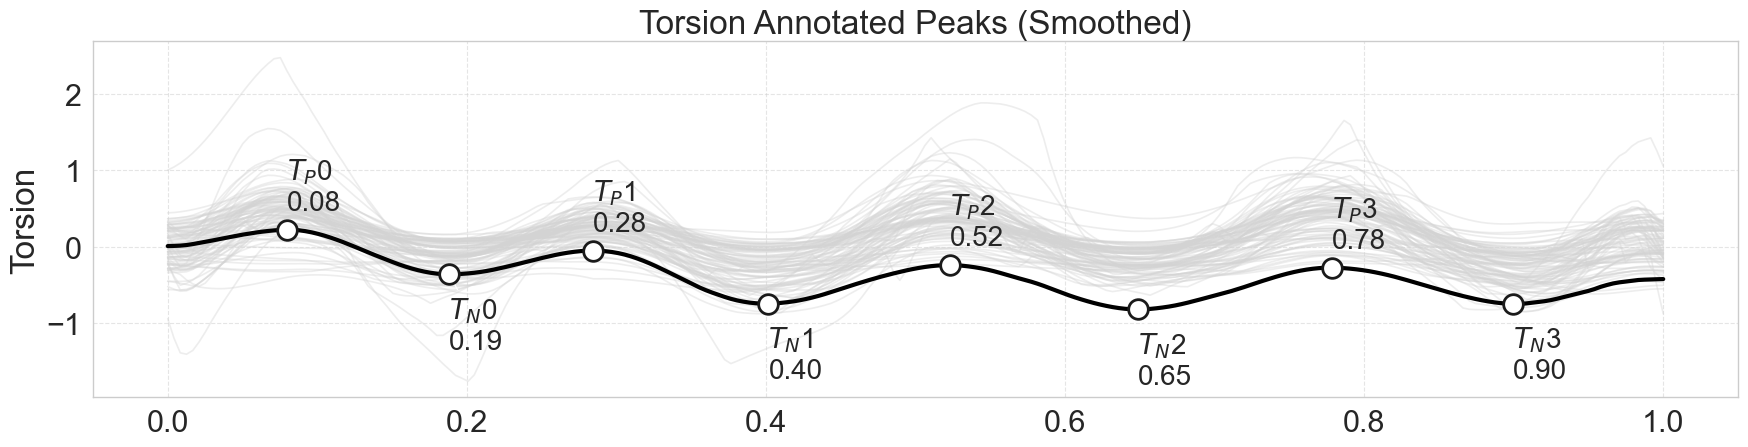

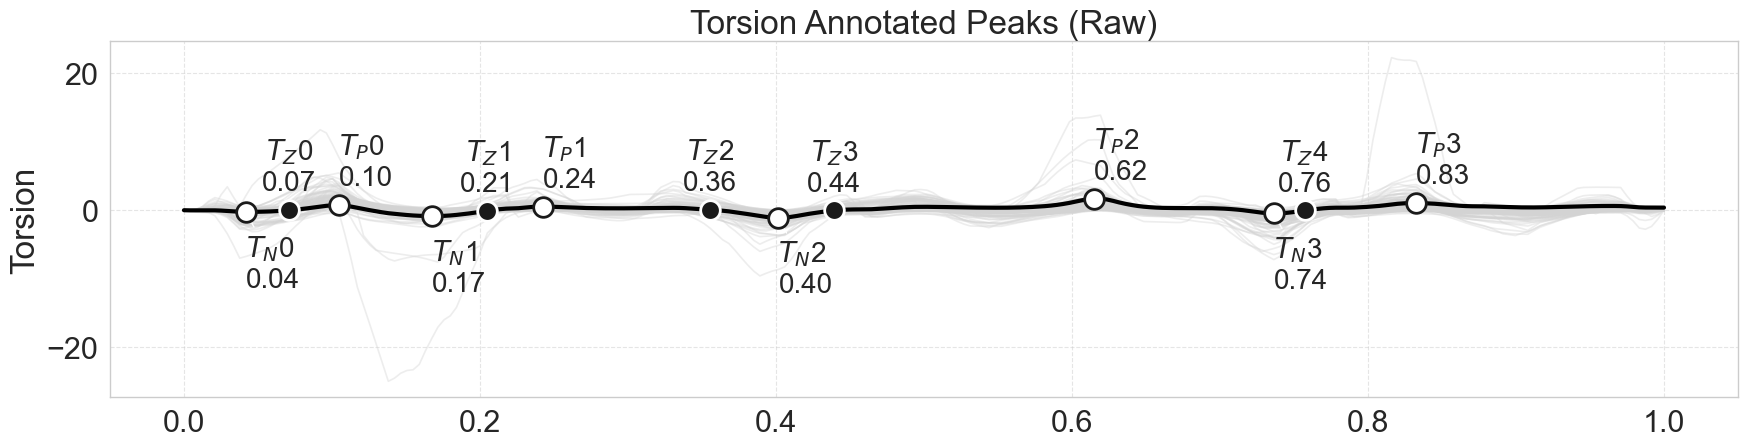

In [86]:
import seaborn as sns
from scipy.signal import find_peaks

sns.set(style="whitegrid", context="paper", font_scale=2.5)

for label in ['Smoothed', 'Raw']:
    obj_weighted = results[label]['obj_weighted']
    f_weighted_unwrapped = results[label]['f_weighted_unwrapped']
    W = results[label]['W']
    f = results[label]['f']

    # mean_torsion = obj_weighted.fmean / W.mean(axis=1)
    mean_torsion = obj_weighted.fmean

    # ----------------------------
    # 正峰值
    peaks_t, _ = find_peaks(
        mean_torsion,
        prominence=(np.max(mean_torsion) - np.min(mean_torsion)) * 0.08,
        distance=TARGET_N // 10
    )
    sorted_peaks_t = peaks_t[np.argsort(time[peaks_t])]

    # ----------------------------
    # 负峰值
    neg_peaks, _ = find_peaks(
        -mean_torsion,
        prominence=(np.max(mean_torsion) - np.min(mean_torsion)) * 0.08,
        distance=TARGET_N // 10
    )
    sorted_neg_peaks = neg_peaks[np.argsort(time[neg_peaks])]


    # ----------------------------
    # 正负反转的零点（排除几乎为 0 的）
    signs = np.sign(mean_torsion)
    sign_changes = np.where(np.diff(signs) != 0)[0]
    sign_change_valid = [i for i in sign_changes if abs(mean_torsion[i]) > 0.01 and abs(mean_torsion[i + 1]) > 0.01]
    # zero_indices = np.array(sign_change_valid)
    zero_indices = np.array(sign_change_valid, dtype=int)
    zero_x = time[zero_indices]
    zero_y = mean_torsion[zero_indices]

    # ----------------------------
    # 可视化
    fig = plt.figure(figsize=(18, 5))
    ax = fig.add_subplot(111)

    for i in range(f.shape[1]):
        ax.plot(time, f_weighted_unwrapped[:, i], alpha=0.4, color='lightgray')

    ax.plot(time, mean_torsion, label='Weighted Mean (deweighted)', lw=3, color='black')

    # 正峰值
    ax.scatter(time[sorted_peaks_t], mean_torsion[sorted_peaks_t],
               color='white', edgecolors='k', linewidths=2,
               s=200, zorder=10, label='Positive Peaks')
    for i, idx in enumerate(sorted_peaks_t):
        peak_x = time[idx]
        peak_y = mean_torsion[idx]
        ax.annotate(f"$T_P${i}\n{peak_x:.2f}", xy=(peak_x, peak_y),
                    xytext=(0, 10), textcoords='offset points',
                    ha='left', va='bottom', fontsize=20,
                    arrowprops=dict(arrowstyle='-', lw=1))

    # 负峰值
    ax.scatter(time[sorted_neg_peaks], mean_torsion[sorted_neg_peaks],
               color='w', edgecolors='k', linewidths=2,
               s=200, zorder=10, label='Negative Peaks')
    for i, idx in enumerate(sorted_neg_peaks):
        peak_x = time[idx]
        peak_y = mean_torsion[idx]
        ax.annotate(f"$T_N${i}\n{peak_x:.2f}", xy=(peak_x, peak_y),
                    xytext=(0, -15), textcoords='offset points',
                    ha='left', va='top', fontsize=20,
                    arrowprops=dict(arrowstyle='-', lw=1))

    # 零点（正负反转）
    ax.scatter(zero_x, zero_y,
               color='k', edgecolors='w', linewidths=2,
               marker='o', s=200, zorder=10, label='Sign Change')
    for i, idx in enumerate(zero_indices):
        peak_x = time[idx]
        peak_y = mean_torsion[idx]
        ax.annotate(f"$T_Z${i}\n{peak_x:.2f}", xy=(peak_x, peak_y),
                    xytext=(0, 10), textcoords='offset points',
                    ha='center', va='bottom', fontsize=20,
                    arrowprops=dict(arrowstyle='-', lw=1))

    ax.set_ylabel("Torsion")
    ax.set_title(f"Torsion Annotated Peaks ({label})")
    plt.grid(linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


In [87]:
import os
import numpy as np
from scipy.signal import find_peaks
from scipy.interpolate import PchipInterpolator
import vtk
from vtk.util import numpy_support

def extract_peaks_and_zeros(signal):
    peaks_pos, _ = find_peaks(signal, prominence=0.05)
    peaks_neg, _ = find_peaks(-signal, prominence=0.05)
    signs = np.sign(signal)
    zeros = np.where(np.diff(signs) != 0)[0]
    zeros = [i for i in zeros if abs(signal[i]) > 0.01 and abs(signal[i+1]) > 0.01]
    return np.asarray(peaks_pos), np.asarray(peaks_neg), np.asarray(zeros)

def create_binary_mask(length, indices):
    arr = np.zeros(length, dtype=np.uint8)
    arr[np.clip(indices, 0, length-1)] = 1
    return arr

def invert_gamma(gamma):
    T = len(gamma)
    x = np.linspace(0, 1, T)
    return PchipInterpolator(gamma, x, extrapolate=True)

def map_mask_back(indices, gamma, target_len, value=1):
    T = len(gamma)
    x = np.linspace(0, 1, T)
    gamma_inv = invert_gamma(gamma)
    mapped = gamma_inv(x[indices])
    idx = np.clip(np.round(mapped * target_len).astype(int), 0, target_len - 1)
    arr = np.zeros(target_len, dtype=np.uint8)
    arr[idx] = value
    return arr

def write_vtk_with_annotations(input_path, output_path, annotations):
    reader = vtk.vtkPolyDataReader()
    reader.SetFileName(input_path)
    reader.Update()
    polydata = reader.GetOutput()
    for name, array in annotations.items():
        vtk_array = numpy_support.numpy_to_vtk(array, deep=True, array_type=vtk.VTK_UNSIGNED_CHAR)
        vtk_array.SetName(name)
        polydata.GetPointData().AddArray(vtk_array)
    writer = vtk.vtkPolyDataWriter()
    writer.SetFileName(output_path)
    writer.SetInputData(polydata)
    writer.Write()

# ====== 参数 ======
T = 200
output_dir = os.path.join(base_dir, "with_curv_torsion_annotations")
os.makedirs(output_dir, exist_ok=True)

# ====== 注释源数据 ======
mean_curv = results['Smoothed']['obj_weighted'].fmean / results['Smoothed']['W'].mean(axis=1)
curv_peaks = find_peaks(mean_curv, prominence=0.05)[0]

# torsion 加权版
mean_torsion_s = results['Smoothed']['obj_weighted'].fmean / results['Smoothed']['W'].mean(axis=1)
tp_s, tn_s, tz_s = extract_peaks_and_zeros(mean_torsion_s)

# torsion 普通版
mean_torsion_r = results['Raw']['obj_weighted'].fmean / results['Raw']['W'].mean(axis=1)
tp_r, tn_r, tz_r = extract_peaks_and_zeros(mean_torsion_r)

gammas_plain = results['Smoothed']['obj_plain'].gam
gammas_weighted = results['Smoothed']['obj_weighted'].gam

# ====== 遍历文件写入 ======
for i, fname in enumerate(vtk_data_dict.keys()):
    gamma_plain = gammas_plain[:, i]
    gamma_weighted = gammas_weighted[:, i]
    coords = vtk_data_dict[fname]["coords"]
    n_points = len(coords)

    annotations = {
        # curvature peaks
        "plain_curvature_peaks": map_mask_back(curv_peaks, gamma_plain, n_points),
        "weighted_curvature_peaks": map_mask_back(curv_peaks, gamma_weighted, n_points),

        # smoothed torsion
        "plain_torsion_tp": map_mask_back(tp_s, gamma_plain, n_points, value=1),
        "plain_torsion_tn": map_mask_back(tn_s, gamma_plain, n_points, value=2),
        "plain_torsion_tz": map_mask_back(tz_s, gamma_plain, n_points, value=3),

        "weighted_torsion_tp": map_mask_back(tp_s, gamma_weighted, n_points, value=1),
        "weighted_torsion_tn": map_mask_back(tn_s, gamma_weighted, n_points, value=2),
        "weighted_torsion_tz": map_mask_back(tz_s, gamma_weighted, n_points, value=3),

        # raw torsion
        "plain_torsion_tp_raw": map_mask_back(tp_r, gamma_plain, n_points, value=1),
        "plain_torsion_tn_raw": map_mask_back(tn_r, gamma_plain, n_points, value=2),
        "plain_torsion_tz_raw": map_mask_back(tz_r, gamma_plain, n_points, value=3),

        "weighted_torsion_tp_raw": map_mask_back(tp_r, gamma_weighted, n_points, value=1),
        "weighted_torsion_tn_raw": map_mask_back(tn_r, gamma_weighted, n_points, value=2),
        "weighted_torsion_tz_raw": map_mask_back(tz_r, gamma_weighted, n_points, value=3)
    }

    input_path = os.path.join(base_dir, fname)
    output_path = os.path.join(output_dir, fname)
    write_vtk_with_annotations(input_path, output_path, annotations)

print(f"✅ Done: annotations saved to {output_dir}")


IndexError: arrays used as indices must be of integer (or boolean) type

In [ ]:
obj = results['Smoothed']['obj_weighted']  # 或 Raw 版本
print("gamma:", hasattr(obj, 'gam'))
if hasattr(obj, 'gam'):
    print("gamma shape:", obj.gam.shape)


gamma: True
gamma shape: (120, 91)


In [ ]:
# import pickle

# # 保存字典为 pkl 文件
# output_path = "vtk_data_dict.pkl"
# with open(output_path, "wb") as f:
#     pickle.dump(vtk_data_dict, f)

# print(f"字典已保存为: {output_path}")


In [ ]:
from fdasrsf.time_warping import fdawarp
print(hasattr(fdawarp, "srsf_align_weighted"))  # 应该输出 True



True
